## Cross-dataset IPF Alveolar Fibroblast analysis, figures, marker gene identification

#### Structure

* [Global variables and paths](#bullet1)
* [Loading data](#bullet2)
* [Pre-processing](#bullet3)
* [Main](#bullet4)
* [Save](#bullet6)

### Environment setup

In [1]:
# basic modules
import warnings, os, sys

In [2]:
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

In [3]:
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
sys.path.append("../../scripts/")
import analysis

In [4]:
sc.logging.print_versions()

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                 9.2.0
analysis            NA
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
cffi                1.15.1
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.2
decorator           5.1.1
defusedxml          0.7.1
entrypoints         0.4
h5py                3.7.0
igraph              0.9.11
ipykernel           6.15.1
ipython_genutils    0.2.0
jedi                0.18.1
joblib              1.1.0
jupyter_server      1.18.1
kiwisolver          1.4.4
leidenalg           0.8.10
llvmlite            0.39.0
matplotlib          3.5.2
mpl_toolkits        NA
natsort             8.1.0
nbinom_ufunc        NA
numba               0.56.0
numexpr             2.8.3
numpy               1.21.6
packaging           21.3
pandas              1.3.5
parso               0.8.3
pexpect             4.8.0
pickleshare         0.7.5
pkg_resources       NA
prompt_toolkit      3.0.30
psu

In [5]:
# setting visualisation parameters
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
fz = 12
plt.rcParams["figure.figsize"] = (4, 4)
plt.rcParams["xtick.labelsize"] = fz
plt.rcParams["ytick.labelsize"] = fz
plt.rcParams["axes.labelsize"] = fz
plt.rcParams["font.size"] = fz
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.grid"] = False

In [6]:
%load_ext lab_black

### Global variables and paths <a class="anchor" id="bullet1"></a>

In [7]:
adata_inp = "../../data/HLCA_extended/extension_disease/scarches_emb_ipf_alveolar-fibroblasts.h5ad"  # alveolar fibroblast object prepared in previous notebook
edata_inp = "../../data/HLCA_extended/HLCA_extended/HLCA_extended_full.h5ad"  # full HLCA including raw counts
path_celltype_colors = "../../supporting_files/celltype_structure_and_colors/manual_anns_grouped_order_and_colors.csv"  # colors per cell type
path_hlca_full_emb = "../../data/HLCA_extended/HLCA_extended/HLCA_extended_scarches_emb.h5ad"  # embedding of full HLCA including UMAP for plotting
dir_dea_results = "../../results/DEAs/alv_fibs_IPF_cluster/"  # directory to store differential expression analysis results in
dir_figures = "../../results/figures/"  # directory to store figures in

initiate empty dictionary to store paper figures in:

In [8]:
FIGURES = dict()

### Loading data <a class="anchor" id="bullet2"></a>

Load celltype colors used across paper, for umaps generated at the bottom of this notebook:

In [9]:
celltype_colors = pd.read_csv(path_celltype_colors, index_col=0)

Load the embedding of alveolar fibroblasts from control + IPF patients as prepared in the previous notebook.

In [10]:
embed_disease = sc.read(adata_inp)

Load the counts from the full HLCA. We will copy the counts from the alveolar fibroblasts from that full object. To save time and memory, we load it in "backed" mode.

In [11]:
edata = sc.read(edata_inp, backed="r")

### Pre-processing <a class="anchor" id="bullet3"></a>

Subset full counts matrix to HLCA_core + IPF datasets only and assign to a new AnnData object.

In [12]:
barcodes = embed_disease.obs_names.intersection(
    edata.obs_names
)  # get barcodes present both in alveolar fibroblast object and the full hlca
print(f"{len(barcodes)}/{embed_disease.shape[0]}")  # numbers should be identical
adata_comb = edata[
    barcodes
].to_memory()  # now store the alv. fib. counts in a new object and load to memory

21496/21496


Check that our counts AnnData object corresponds to the disease embedding object in terms of row (=cell) order:

In [13]:
(adata_comb.obs_names == embed_disease.obs_names).all()

True

Copy obsm (UMAP etc.) from disease_embedding (for which we calculated UMAP previously), plus copy missing .obs columns from embedding to full-gene disease object.

In [14]:
missing_obs_columns = [
    i for i in embed_disease.obs.columns if not i in adata_comb.obs.columns
]
df = embed_disease.obs.loc[:, missing_obs_columns]
print(f"Adding {df.shape[1]} .obs columns from embedding to full counts object.")
# concatenate to .obs
adata_comb.obs = pd.concat([adata_comb.obs, df], axis=1)
adata_comb.obsm = embed_disease[adata_comb.obs_names].obsm

Adding 7 .obs columns from embedding to full counts object.


Calculate (log10 of) total number of counts per cell:

In [15]:
adata_comb.obs["total_counts"] = adata_comb.X.sum(axis=1)

In [16]:
adata_comb.obs["log10_total_counts"] = np.log10(adata_comb.obs.total_counts)

check if counts look raw:

In [17]:
adata_comb.X[:10, :10].toarray()

array([[ 0.,  0.,  0.,  0., 18.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., 10.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  8.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0., 54.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., 25.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  5.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., 17.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  7.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]], dtype=float32)

In [21]:
adata_comb.X[-10:, -10:].toarray()

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

Now normalize and log-transform counts:

In [22]:
sc.pp.normalize_total(
    adata_comb, target_sum=7699
)  # 7699 is median total counts across HLCA

In [23]:
sc.pp.log1p(adata_comb)

Reduce genes: filter out genes expressed in few cells or genes expressed in a single dataset.

Filtering based on number of cells that express the gene. Remove all genes observed in fewer than 20 cells.

In [24]:
adata_comb.shape  # shape before first filtering

(21496, 59586)

In [25]:
sc.pp.filter_genes(adata_comb, min_cells=20)

In [26]:
adata_comb.shape  # shape after basic filtering

(21496, 19929)

Filter out study-specific genes, using groupby (as we are looking for patterns consistent across datasets, we are not interested in genes expressed in a single dataset).

In [27]:
adata_comb_genedf = pd.DataFrame(
    adata_comb.X.toarray(), index=adata_comb.obs.index, columns=adata_comb.var.index
)

In [28]:
genes = adata_comb_genedf.columns

In [29]:
adata_comb_genedf["study"] = adata_comb.obs["study"]

In [30]:
genedf_study = adata_comb_genedf.groupby("study").agg({gene: "sum" for gene in genes})

In [31]:
gene_in_multiple_studies = (genedf_study > 0).sum(axis=0) > 1
gene_in_multiple_studies = gene_in_multiple_studies.loc[
    gene_in_multiple_studies.values
].index.tolist()

Number of genes observed in multiple studies:

In [32]:
len(gene_in_multiple_studies)

18508

Now subset the adata object to the genes that passed filtering:

In [33]:
adata_comb = adata_comb[:, gene_in_multiple_studies].copy()

Reorder cells in adata, so that plotting order of cells in umaps is random:

In [34]:
index_list = adata_comb.obs.index.tolist()
np.random.shuffle(index_list)
adata_comb = adata_comb[index_list, :]

Simplify lung condition labeling. We will set "End-stage lung fibrosis, unknown etiology" simply to IPF, and tumor-adjacent non-tumorous tissue to healthy (as done in the rest of the project). Final counts of both categories are printed below.

In [37]:
adata_comb.obs["condition"].value_counts()
condition_renamer = {i: i for i in adata_comb.obs.condition.cat.categories}
condition_renamer["End-stage lung fibrosis, unknown etiology"] = "IPF"
condition_renamer["Healthy (tumor adjacent)"] = "Healthy"
condition_renamer
adata_comb.obs["condition"] = pd.Categorical(
    adata_comb.obs.condition.map(condition_renamer)
)
adata_comb.obs["condition"].value_counts()

Healthy    16411
IPF         5085
Name: condition, dtype: int64

### Main <a class="anchor" id="bullet4"></a>

Show clustering in umap (both calculated in previous notebook):

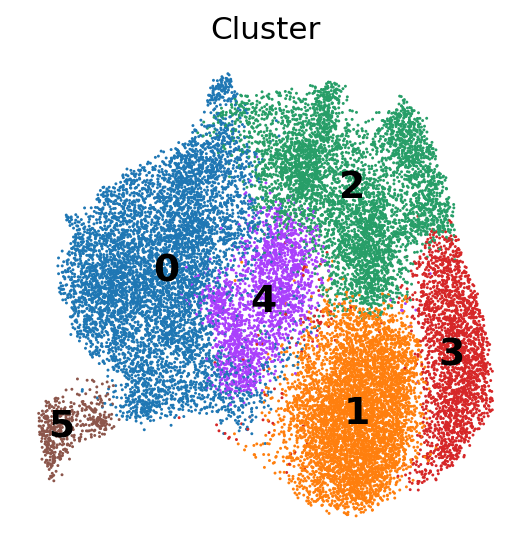

In [38]:
FIGURES["6f_umap_clusters"] = sc.pl.umap(
    embed_disease,
    color="leiden_0.3",
    size=7,
    frameon=False,
    wspace=0.6,
    return_fig=True,
    title="Cluster",
    legend_fontsize=fz + 5,
    legend_loc="on data",
)

print number of cells per cluster (this info needs to be included in the manuscript, as we do a statistical test on cluster 0)

In [39]:
n_cluster_0 = embed_disease.obs["leiden_0.3"].value_counts()[0]
print("n cells cluster 0:", n_cluster_0)
print("n cells rest:", embed_disease.n_obs - n_cluster_0)

n cells cluster 0: 6653
n cells rest: 14843


Generate .obs variable including study information for IPF datasets, with all other datasets set to healthy:

In [40]:
adata_comb.obs["condition_study"] = [
    f"IPF ({st})" if cond == "IPF" else "Healthy (all studies)"
    for st, cond in zip(adata_comb.obs.study, adata_comb.obs.condition)
]
# sort categories such that healthy is first
adata_comb.obs.condition_study = pd.Categorical(
    adata_comb.obs.condition_study,
    categories=["Healthy (all studies)"]
    + [
        cat
        for cat in sorted(adata_comb.obs.condition_study.unique())
        if not cat.startswith("Healthy")
    ],
)

Use same study coloring scheme as for MDM figures in other notebook:

In [41]:
study2color = {
    "Banovich_Kropski_2020": "#FFFF00",
    "Barbry_Leroy_2020": "#1CE6FF",
    "Budinger_2020": "#FF34FF",
    "Duong_lungMAP_unpubl": "#FF4A46",
    "Eils_2020": "#008941",
    "Janssen_2020": "#006FA6",
    "Kaminski_2020": "#A30059",
    "Krasnow_2020": "#FFDBE5",
    "Lafyatis_2019": "#7A4900",
    "Lafyatis_Rojas_2019": "#0000A6",
    "Lambrechts_2021": "#63FFAC",
    "Meyer_2019": "#B79762",
    "Meyer_2021": "#004D43",
    "Meyer_Nikolic_2022": "#8FB0FF",
    "Misharin_2021": "#997D87",
    "Misharin_Budinger_2018": "#5A0007",
    "Peer_Massague_2020": "#809693",
    "Regev_2021": "#6A3A4C",
    "Schiller_2020": "#1B4400",
    "Schiller_2021": "#4FC601",
    "Schultze_unpubl": "#3B5DFF",
    "Shalek_2018": "#4A3B53",
    "Sheppard_2020": "#FF2F80",
    "Sun_2020": "#61615A",
    "Tata_unpubl": "#BA0900",
    "Teichmann_Meyer_2019": "#6B7900",
    "Thienpont_2018": "#00C2A0",
    "Wunderink_2021": "#FFAA92",
    "Xu_2020": "#FF90C9",
    "Zhang_2021": "#B903AA",
}

Make IPF study categories correspond to colors above:

In [42]:
disstudy2color = {
    "Healthy (all studies)": "#e4e4e4",
    "IPF (Sheppard_2020)": study2color["Sheppard_2020"],
    "IPF (Kaminski_2020)": study2color["Kaminski_2020"],
    "IPF (Banovich_Kropski_2020)": study2color["Banovich_Kropski_2020"],
    "IPF (Schiller_2020)": study2color["Schiller_2020"],
    "IPF (Misharin_Budinger_2018)": study2color["Misharin_Budinger_2018"],
}

Plot barplot showing IPF study composition per cluster, setting all cells from healthy individuals to "Healthy":

In [43]:
sc.set_figure_params()

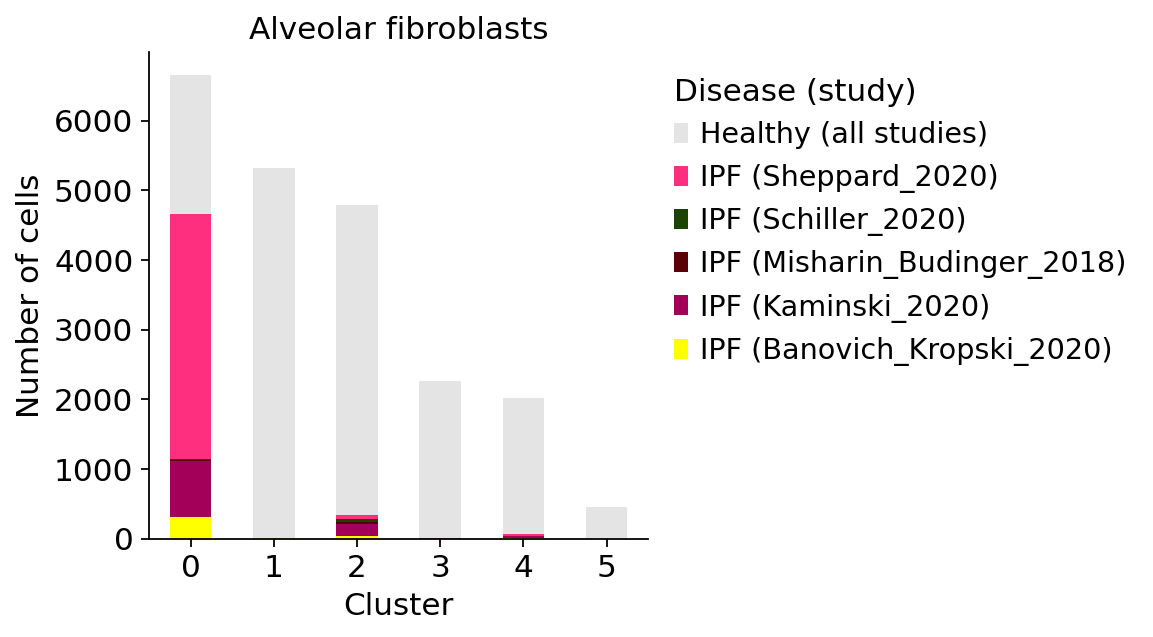

In [44]:
i = "leiden_0.3"
j = "condition_study"
df = adata_comb.obs.copy()
df_plot = pd.crosstab(df[i], df[j])
df_plot = df_plot.loc[
    :,
    [col for col in df_plot.columns if not col.startswith("Healthy")]
    + ["Healthy (all studies)"],
]
fig, ax = plt.subplots()
df_plot.plot(
    kind="bar",
    stacked=True,
    legend=False,
    color=disstudy2color,
    ax=ax,
)

handles, labels = ax.get_legend_handles_labels()
leg = plt.legend(
    handles[::-1],
    labels[::-1],
    bbox_to_anchor=(1, 1, 0, 0),
    ncol=1,
    frameon=False,
    title="Disease (study)",
)
leg._legend_box.align = "left"
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.xlabel("Cluster")
plt.ylabel("Number of cells")
plt.grid(False)
plt.title("Alveolar fibroblasts")
plt.tick_params(axis="x", rotation=0)
FIGURES["6g_barplot_alv_fibs_cluster_IPF_study.png"] = fig
plt.show()

Also plot general study composition per cluster (both healthy and IPF):

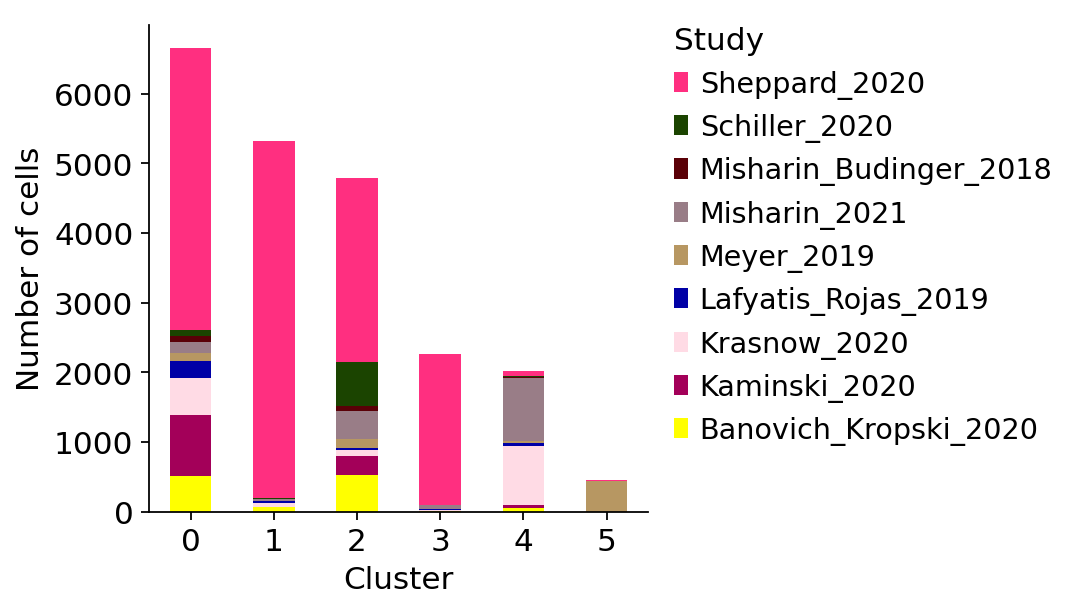

In [45]:
i = "leiden_0.3"
j = "study"
df = adata_comb.obs.copy()
df_plot = pd.crosstab(df[i], df[j])
fig, ax = plt.subplots()
df_plot.plot(kind="bar", stacked=True, legend=False, ax=ax, color=study2color)

handles, labels = ax.get_legend_handles_labels()
leg = plt.legend(
    handles[::-1],
    labels[::-1],
    bbox_to_anchor=(1, 1.05, 0, 0),
    ncol=1,
    frameon=False,
    title="Study",
)
leg._legend_box.align = "left"
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.xlabel("Cluster")
plt.ylabel("Number of cells")
ax.grid(False)
plt.xticks(rotation=0)
FIGURES["ED10b_barplot_alv_fibs_cluster_study"] = fig
plt.show()

Let's do a differential expression analysis on the clusters to find genes differentially expressed per cluster.

In [46]:
sc.tl.rank_genes_groups(adata_comb, groupby="leiden_0.3", method="wilcoxon")

Some filtering to find genes that are strongly differentially expressed:

In [47]:
sc.tl.filter_rank_genes_groups(
    adata_comb,
    key="rank_genes_groups",
    key_added="rank_genes_groups_filtered",
    min_in_group_fraction=0.3,
    max_out_group_fraction=0.2,
)

Now plot some of the results in a dotplot:

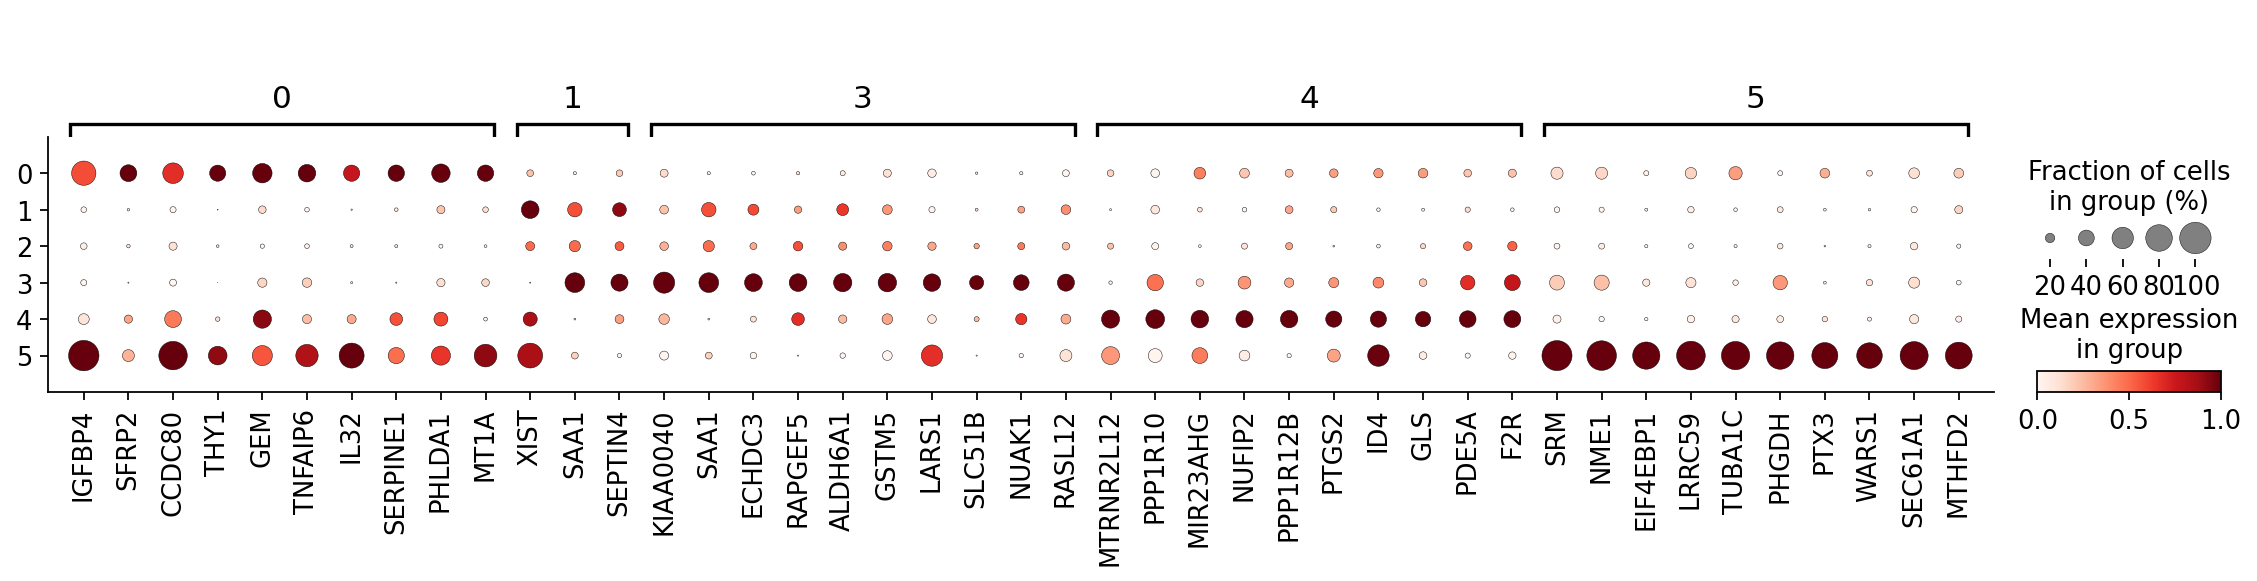

In [48]:
sc.pl.rank_genes_groups_dotplot(
    adata_comb,
    groupby="leiden_0.3",
    dendrogram=False,
    key="rank_genes_groups_filtered",
    n_genes=10,
    standard_scale="var",
)

Cluster 5 is small and looks very different from the rest, this might be specific to a single sample/subject and is therefore not interesting in understanding general trends. To see if that is the case, check subject diversity per cluster:

calculate subject entropy per cluster:

In [50]:
adata_comb = analysis.calculate_cluster_entropy(
    adata_comb, cluster_variable="leiden_0.3", obs_variable="subject_ID"
)

Storing entropy values in obs column entropy_subject_ID_leiden_0.3


print entropies per cluster:

In [51]:
adata_comb.obs.groupby("leiden_0.3").agg({"entropy_subject_ID_leiden_0.3": "first"})

,entropy_subject_ID_leiden_0.3
leiden_0.3,
0,2.949945
1,0.549384
2,2.599586
3,0.420565
4,1.553177
5,0.180764


Print largest single-donor fraction per cluster:

In [52]:
for cl in adata_comb.obs["leiden_0.3"].cat.categories:
    subj_counts = adata_comb.obs.loc[
        adata_comb.obs["leiden_0.3"] == cl, "subject_ID"
    ].value_counts()
    subj_perc = subj_counts / subj_counts.sum() * 100
    print(
        f"Cluster {cl}, largest subject proportion:",
        round(subj_perc.sort_values(ascending=False)[0], 1),
    )

Cluster 0, largest subject proportion: 22.5
Cluster 1, largest subject proportion: 89.6
Cluster 2, largest subject proportion: 25.4
Cluster 3, largest subject proportion: 92.7
Cluster 4, largest subject proportion: 43.7
Cluster 5, largest subject proportion: 96.3


As cluster 5 has subject entropy below the threshold used in the paper, we will exclude it:

In [53]:
adata_comb_no_cl5 = adata_comb[adata_comb.obs["leiden_0.3"] != "5", :].copy()

Select final markers for cluster 0 based on markers from differential expression analysis, and literature-based IPF fibroblast markers.

In [54]:
markers = [
    "CCL2",
    "CTHRC1",
    "SERPINE1",
    "HIF1A",
    "COL1A1",
    "MMP19",
]

Generate variable that splits clusters by disease and study, for plotting:

In [55]:
adata_comb.obs["cluster_disease_study"] = [
    f"{x} ({y}, {z})" if x == "0" else x
    for x, y, z in zip(
        adata_comb.obs["leiden_0.3"],
        adata_comb.obs.condition,
        adata_comb.obs.study,
    )
]

Show marker expression per cluster, splitting cluster 0 by study and health status to see if cluster 0 markers are consistently expressed across studies, in particular for the IPF subset (note that gene counts are not batch corrected, and so some variance between studies is expected).

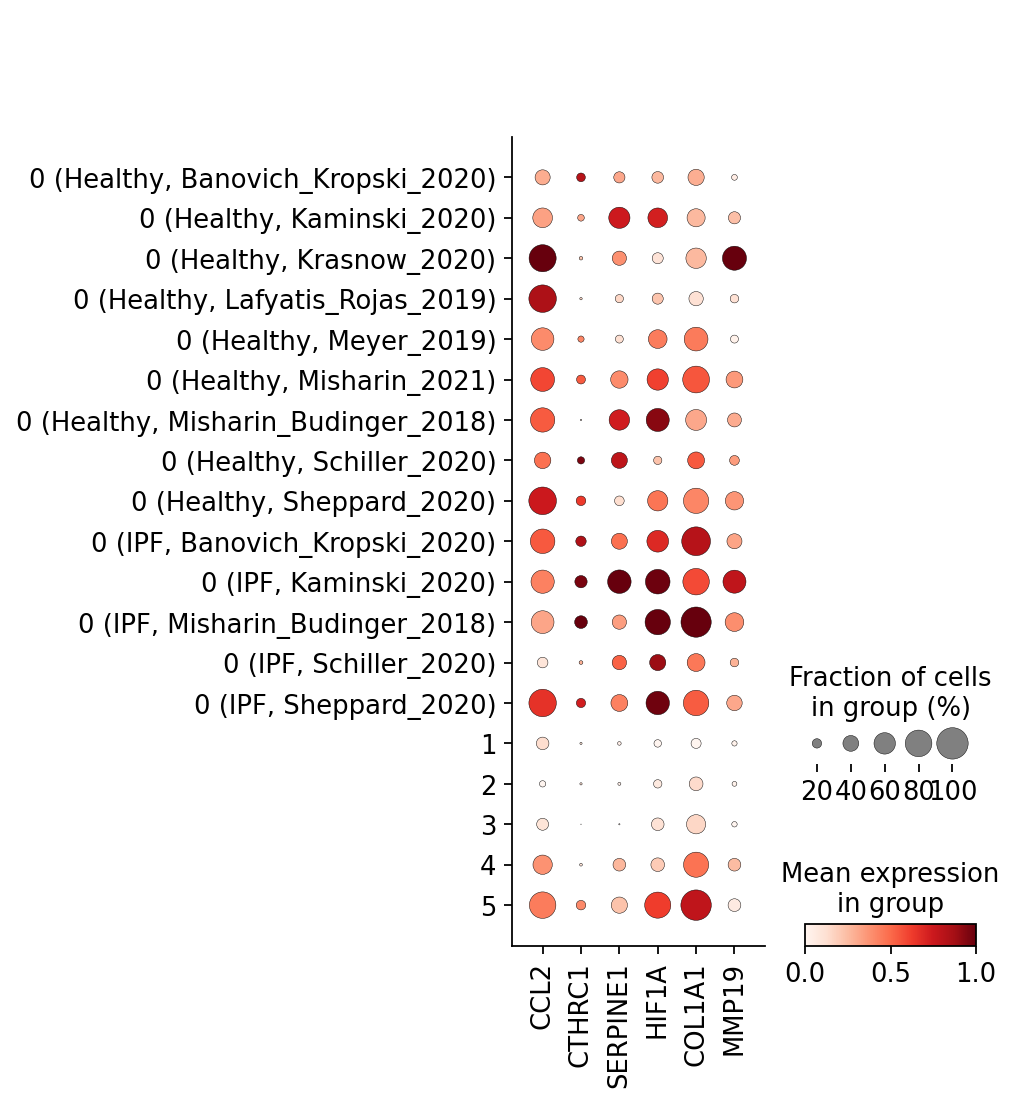

In [57]:
FIGURES["ED10c_dotplot_alv_fibs_IPF_markers_cluster_disease_study"] = sc.pl.dotplot(
    adata_comb,
    markers,
    groupby="cluster_disease_study",
    standard_scale="var",
    return_fig=True,
)
FIGURES["ED10c_dotplot_alv_fibs_IPF_markers_cluster_disease_study"].show()

Not plot gene expression per cluster, not splitting by study:

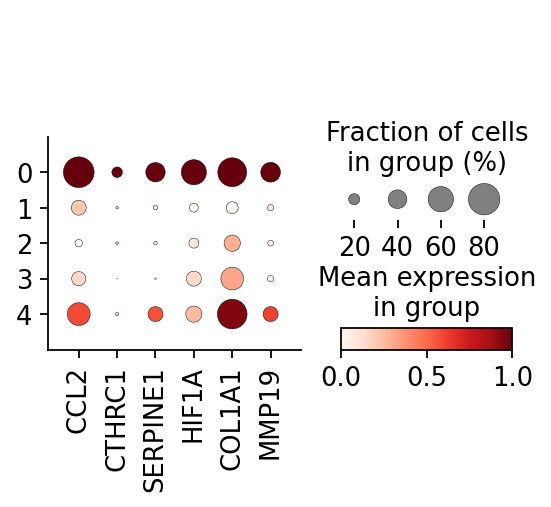

In [58]:
FIGURES["6h_dotplot_alv_fibs_IPF_markers"] = sc.pl.dotplot(
    adata_comb_no_cl5,
    markers,
    groupby="leiden_0.3",
    standard_scale="var",
    return_fig=True,
)
FIGURES["6h_dotplot_alv_fibs_IPF_markers"].show()

load full embedding with clean metadata for umap plot:

In [59]:
emb_full = sc.read_h5ad(path_hlca_full_emb)

In [60]:
emb_full.obs["alveolar_fibroblasts"] = "Other"
emb_full.obs.loc[adata_comb.obs.index, "alveolar_fibroblasts"] = "Alveolar fibroblasts"

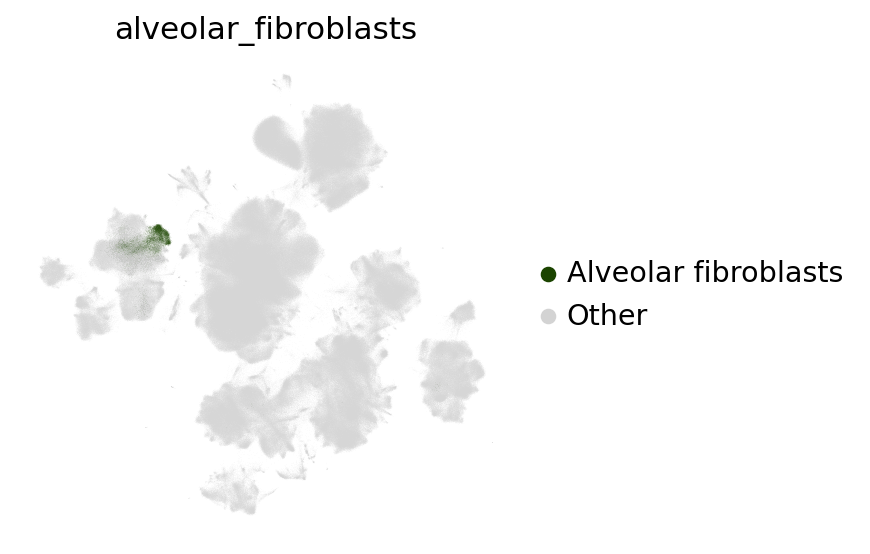

In [61]:
FIGURES["6f_umap_full_alv_fibs"] = sc.pl.umap(
    emb_full,
    color="alveolar_fibroblasts",
    palette={
        "Other": "lightgrey",
        "Alveolar fibroblasts": celltype_colors.loc["Alveolar fibroblasts", "color"],
    },
    frameon=False,
    return_fig=True,
)

# Save results:

Save differentially expressed gene results. We will save them only for the IPF enriched cluster, as this was the focus for the analysis:

In [62]:
degs = (
    sc.get.rank_genes_groups_df(adata_comb, group="0", key="rank_genes_groups_filtered")
    .dropna(how="any", axis=0)
    .set_index("names")
)

In [63]:
degs.to_csv(
    os.path.join(dir_dea_results, "DEGs_alv_fibs_IPFenriched_cluster_0_filtered.csv")
)

Save figures:

In [66]:
for figname, fig in FIGURES.items():
    print("Storing", figname)
    fig.savefig(
        os.path.join(dir_figures, f"{figname}.png"),
        bbox_inches="tight",
        dpi=140,
        transparent=True,
    )
    plt.close()

Storing 6f_umap_clusters
Storing 6g_barplot_alv_fibs_cluster_IPF_study.png
Storing ED10b_barplot_alv_fibs_cluster_study
Storing ED10c_dotplot_alv_fibs_IPF_markers_cluster_disease_study
Storing 6h_dotplot_alv_fibs_IPF_markers
Storing 6f_umap_full_alv_fibs
